In [1]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

In [4]:
%%cl_kernel 
__kernel void heat_eq_2D(__global float *u1, __global const float *u0, float kappa, float dt, float dx, float dy) {
    
    //Get total number of cells
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    //Skip ghost cells
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    //Calculate the four indices of our neighboring cells
    int center = j*nx + i;
    int north = (j+1)*nx + i;
    int south = (j-1)*nx + i;
    int east = j*nx + (i+1);
    int west = j*nx + (i-1);
    
    //Internal cells
    if (i > 0 && i < nx-1 && j > 0 && j < ny-1) {
        u1[center] = u0[center]  
        + (kappa*dt/(dx*dx) * (u0[west] - 2*u0[center] + u0[east]))
        + (kappa*dt/(dy*dy) * (u0[south] - 2*u0[center] + u0[north]));
    }
    //Boundary conditions (ghost cells)
    else { 
        u1[center] = u0[center];
    }
}

/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i5-5257U CPU @ 2.70GHz' on 'Intel(R) OpenCL' at 0x24d50b8> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <heat_eq_2D> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)


In [21]:
"""
Class that holds data for the heat equation in OpenCL
"""
class HeatDataCL:
    """
    Uploads initial data to the CL device
    """
    def __init__(self, u0):
        #Make sure that the data is single precision floating point
        assert(np.issubdtype(u0.dtype, np.float32))
        
        #Find number of cells
        self.nx = u0.shape[0] # number of cells at x dimm
        self.ny = u0.shape[1] # number of cells at y dimm
        
        mf = cl.mem_flags 
        
        #Upload data to the device
        self.u0 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
        #Allocate output buffers
        self.u1 = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
        
    """
    Enables downloading data from CL device to Python
    """
    def download(self):
        #Allocate data on the host for result
        u0 = np.empty((self.nx, self.ny), dtype=np.float32)
        
        #Copy data from device to host
        cl.enqueue_copy(cl_queue, u0, self.u0)
        
        #Return
        return u0;

In [22]:
"""
Computes the heat equation using an explicit finite difference scheme with OpenCL
"""
def opencl_heat_eq(cl_data, kappa, dx, dy, nt):
    #Calculate dt from the CFL condition
    dt = 0.4 * min(dx*dx / (2.0*kappa), dy*dy / (2.0*kappa))

    #Loop through all the timesteps
    for i in range(nt):
        #Execute program on device
        heat_eq_2D(cl_queue, (cl_data.nx, cl_data.ny), None, cl_data.u1, cl_data.u0, numpy.float32(kappa), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy))
        
        #Swap variables
        cl_data.u0, cl_data.u1 = cl_data.u1, cl_data.u0

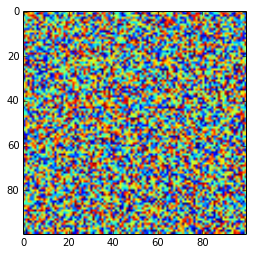

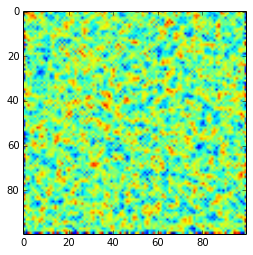

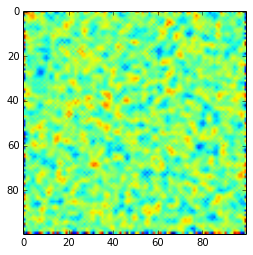

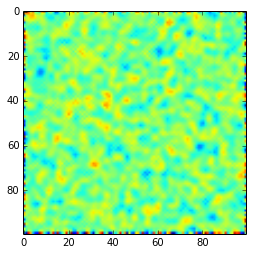

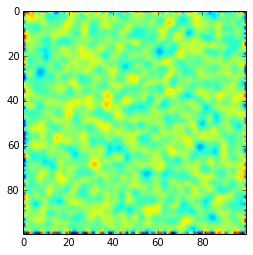

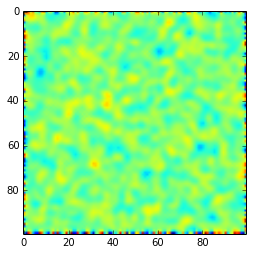

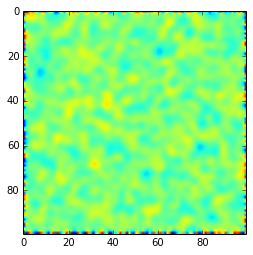

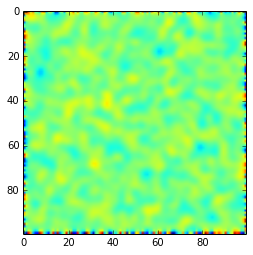

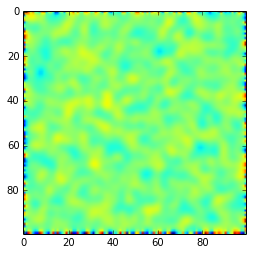

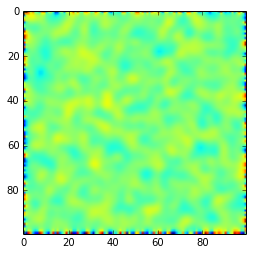

In [33]:
#Create test input data
u0 = np.random.rand(ny, nx).astype(np.float32)
cl_data = HeatDataCL(u0)
kappa = 1.0
dx = 1.0
dy = 1.0

#Plot initial conditions
figure()
imshow(u0)

#plot(u0, legend="u0") // only for plotting lines and curves

# put less than 20 iterations
for i in range(1, 10):
    
    # nt parameter at opencl_heat_eq, t times to calculate and plot the results
    timesteps_per_plot = 1
    
    #Simulate 10 timesteps
    opencl_heat_eq(cl_data, kappa, dx, dy, timesteps_per_plot)

    #Download data
    u1 = cl_data.download()

    #Plot
    figure() # display on separate img
    imshow(u1)
    
#legend()